In [1]:
IRdisplay::display_html(file='code_hiding.html')

Toggle ON/OFF 
code cells.

**Author**: Adrian Ernesto Radillo
**Date**: 19 Feb 2019

# Introduction
## Notebook's goals

Analyze data collected on myself. Two subgoals:
1. make sure the task and stimulus behave as we want, to the smallest detail
2. start building up an analysis pipeline for the actual study

### Immediate results
1. First trial shows _weird_ timing, and first five to ten trials in general have an abnormally long delay between `trialStart` and `fixationOn`. So, based on some tolerance level, we should discard the first few trials.
2. This document is a series of basic questions that I ask about the data, and that I try to answer (with graphs when I can)

## A word on the data for this notebook
The tag for this data is `Pilot 11`. It was collected in the psychophysics booth with [this code](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/releases/tag/pilot11.mat).

I timed with my phone the elapsed time between launching the task via the GUI and the time of closing the GUI.
This roughly amounted to 31 minutes.

## Feedback about my own impressions doing the task
- Luminance on booth's screen is too high (almost hurts my eyes)
- As dots coherence changes, so does the effective speed of the dots. I perceived much faster moving/fluctuating dots at low coherence levels than at high ones. This might be a problem...
- I usually need a few minutes of break every 5 to 10 minutes. I guess it will be the same for the subjects.
- sometimes, and involuntary head or eye movement during stimulus presentation changes the perception of the dots (they become lines). I don't know if the eye-tracker will pick up on that, but if it doesn't it is an issue.
- Getting comfy in front of the screen is ultra important, and not so easy to achieve
- Thus, doing several trials (at least 40) in presence of the experimenter to give him oral, real-time feedback, is really important.


## Data analysis workflow description
1. Task is run with repo [SingleCP_DotsReversal_Task](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/) (appropriate branch must be chosen).
  1. A `.mat` data file is outputted
  2. I usually manually rename this file `pilot#.mat` and upload it to PennBox (location = Data/Psychophysics/Radillo_SingleCP_DotsReversal/)
2. Data is analyzed with repo [SingleCP_DotsReversal_DataAnalaysis](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis)(again, with the appropriate branch).
  1. The first step is to convert data from the .mat file into CSV format with [this script](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/blob/02109ab98b956f2aad4ac15f01e1d373260c8af0/MATLAB_scripts/mat2csv.m) 
    - `pilot#_framesInfo.csv` [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-description-of-*framesInfo.csv-file).
    - `pilot#_FIRA.csv`  [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-Description-of-*FIRA.csv-files).
    - `pilot#_dotsPositions.csv` [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-descriptions-for-*dotsPositions.csv-file).

**TO-DO**
- There is a clear problem in the way my code defines change points. This needs to be fixed.
- Write detailed explanation of each column in each `.csv` file (i.e. update the [Wiki](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki))
- With 345 trials, dotsPositions.csv file is already around 80 MB big with more than a million rows! This is too much.
    - I could remove a lot of the 'dumping'
    - I could try to adopt the [NWB](https://www.nwb.org/) data format.

## Unordered questions to address in this notebook
1. How many frames are skipped on each trial, and where in the trial do they occur?
    - Does this number match the offset in viewing duration per trial?
1. Do subjects display a tendency to repeat the answer from the last trial?
1. Do subjects use the dot count in each half of the screen to make up their mind at low coherence levels?
1. Compute reverse kernels with the number of coherent dots as a proxy for motion energy
1. Plot indep var. as fcn of trial count, to ensure real randomization was implemented by the task algorithm.

In [2]:
# load packages and define constants
library(data.table)     # see https://cran.r-project.org/web/packages/data.table/vignettes/datatable-intro.html for reference
library(ggplot2)        # for plots
library(repr)           # for resizing figures
library(OneR)           # to use the function 'bin'
library(gridExtra)      # to use grid.arrange()
source("R_functions.r") # custom functions

# folder/file-specific constants
PILOT_NUMBER <- 11
DATA_FOLDER <- "~/programing/data/psychophys/"
FIRA_TAG <- "FIRA"
FRAMES_TAG <- "framesInfo"
DOTS_TAG <- "dotsPositions"

# plot-specific constants
AXES_LABEL_FONT <- 18
AXES_FONT <- 15
ERROR_WIDTH <- 4
SMALL_ERROR_WIDTH <- .01*ERROR_WIDTH
LINE_WIDTH <- 1.4
POINT_SIZE <- 2

# other variables
FRAME_RATE_ESTIMATE <- 60 # Hz
FRAME_DURATION <- (1 / FRAME_RATE_ESTIMATE) # sec

In [3]:
# load csv files into data.tables
# key-specific constants 
TRIALS <- loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, FIRA_TAG)
FRAMES <- loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, FRAMES_TAG)
DOTS <- loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, DOTS_TAG)

# Data pre-processing
## Summary of `TRIALS` dataset (`*FIRA.csv` file)

In [4]:
str(TRIALS)

Classes ‘data.table’ and 'data.frame':	504 obs. of  27 variables:
 $ taskID         : int  2 2 2 2 2 2 2 2 2 2 ...
 $ trialIndex     : int  887 300 281 564 112 279 892 879 351 184 ...
 $ trialStart     : num  1211394 1211400 1211405 1211409 1211414 ...
 $ trialEnd       : num  1211400 1211405 1211409 1211414 1211418 ...
 $ RT             : num  1.275 0.921 0.86 1.125 0.875 ...
 $ choice         : num  1 0 0 0 0 0 0 1 1 1 ...
 $ correct        : num  1 1 1 1 0 1 0 1 1 0 ...
 $ initDirection  : int  0 180 0 180 180 0 180 0 0 180 ...
 $ endDirection   : int  0 180 180 180 0 180 0 0 0 180 ...
 $ presenceCP     : int  0 0 1 0 1 1 1 0 0 0 ...
 $ coherence      : int  60 60 24 60 12 12 12 12 12 12 ...
 $ viewingDuration: num  0.4 0.5 0.4 0.2 0.5 0.4 0.5 0.4 0.5 0.1 ...
 $ probCP         : num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...
 $ timeCP         : num  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
 $ randSeedBase   : int  7792 1799 73 7113 1651 4120 5616 3316 6353 9185 ...
 $ fixationO

## Summary of `FRAMES` dataset (`*framesInfo.csv` file)

In [5]:
str(FRAMES)

Classes ‘data.table’ and 'data.frame':	11353 obs. of  6 variables:
 $ frameTotCount: int  3 4 5 6 7 8 9 10 11 12 ...
 $ onsetTime    : num  1211394 1211397 1211397 1211397 1211397 ...
 $ onsetFrame   : int  205 392 400 403 404 405 406 407 408 409 ...
 $ swapTime     : num  1211394 1211397 1211397 1211397 1211397 ...
 $ isTight      : int  0 0 0 0 1 1 1 1 1 1 ...
 $ trialIndex   : int  887 887 887 887 887 887 887 887 887 887 ...
 - attr(*, ".internal.selfref")=<externalptr> 


## Summary of `DOTS` dataset (`*dotsPositions.csv` file)

In [6]:
str(DOTS)

Classes ‘data.table’ and 'data.frame':	1713348 obs. of  6 variables:
 $ xpos      : num  0.201 0.322 0.205 0.548 0.362 ...
 $ ypos      : num  0.465 0.293 0.105 0.341 0.515 ...
 $ isActive  : int  1 0 0 1 0 0 1 0 0 1 ...
 $ isCoherent: int  1 0 0 1 0 0 1 0 0 1 ...
 $ frameIdx  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ trialCount: int  1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [7]:
cat("number of active dots per frame appearing across trials",
    unique(DOTS[,.(numDots=sum(isActive)), by=.(trialCount,frameIdx)][,numDots])
    ,"\n")

number of active dots per frame appearing across trials 61 60 


**TODO:Why these two numbers and not a single one?**

## Match trials across datasets

How many trials were produced in each dataset?

In [9]:
cat('TRIALS',nrow(TRIALS),
   '\nDOTS  ',DOTS[,max(trialCount)],
   '\nFRAMES',nrow(FRAMES[,.N,by=trialIndex]))

TRIALS 504 
DOTS   478 
FRAMES 496

We need to get the trials to match across datasets. The trial count from the `DOTS` dataset is the most reliable of the three, in the sense that it is the number of trials which actually resulted in the presentation of the dots stimulus.

In [10]:
cat('trial count with non-NA choice in TRIALS dataset = ',nrow(TRIALS[!is.na(choice)]))

trial count with non-NA choice in TRIALS dataset =  478

The above is a start. We are able to match trials between `TRIALS` and `DOTS` datasets. Thus, let's introduce a `trialCount` column in `TRIALS` to match with `DOTS`. For invalid trials, `trialCount=NA`.

In [11]:
TRIALS[!is.na(choice), trialCount:=.I]
TRIALS[is.na(choice), trialCount := NA_integer_]

In [12]:
# to match TRIALS to FRAMES, we use timestamps. 

# add the trialCount col to FRAMES, with 0 entries for now
FRAMES[,trialCount:=0]
# str(FRAMES)

# NOTE: following for loop is SLOW, but I don't know of a way to speed things up

# loop through rows in FRAMES and set trialCount appropriately
for (numRow in 1:nrow(FRAMES)) {
    frameOnset <- FRAMES[numRow, onsetTime]
    if (length(TRIALS[trialStart <= frameOnset & trialEnd >= frameOnset,trialCount]) == 0) {
        cat('discarding frame from row ',numRow, 'in FRAMES\n')
        FRAMES[numRow, "trialCount"] <- NA_integer_
    } else {
        FRAMES[numRow, "trialCount"] <- TRIALS[trialStart <= frameOnset & trialEnd >= frameOnset,trialCount]
    }
}

cat('new trial count in FRAMES after time filtering',
nrow(FRAMES[!is.na(trialCount),.N,by=trialCount]))

Classes ‘data.table’ and 'data.frame':	11353 obs. of  7 variables:
 $ frameTotCount: int  3 4 5 6 7 8 9 10 11 12 ...
 $ onsetTime    : num  1211394 1211397 1211397 1211397 1211397 ...
 $ onsetFrame   : int  205 392 400 403 404 405 406 407 408 409 ...
 $ swapTime     : num  1211394 1211397 1211397 1211397 1211397 ...
 $ isTight      : int  0 0 0 0 1 1 1 1 1 1 ...
 $ trialIndex   : int  887 887 887 887 887 887 887 887 887 887 ...
 $ trialCount   : num  0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 
discarding frame from row  11353 in FRAMESnew trial count in FRAMES after time filtering 478

Hurray, we managed to match `FRAMES` and `TRIALS`!

# Timing and trial checks
How long did the session last?

In [8]:
cat( round(TRIALS[,sum(trialEnd - trialStart)] / 60, digits = 2), "min" )

31.36 min

## Aborted trials
Did any trial fail?

there are 26 trials where choice = NA:

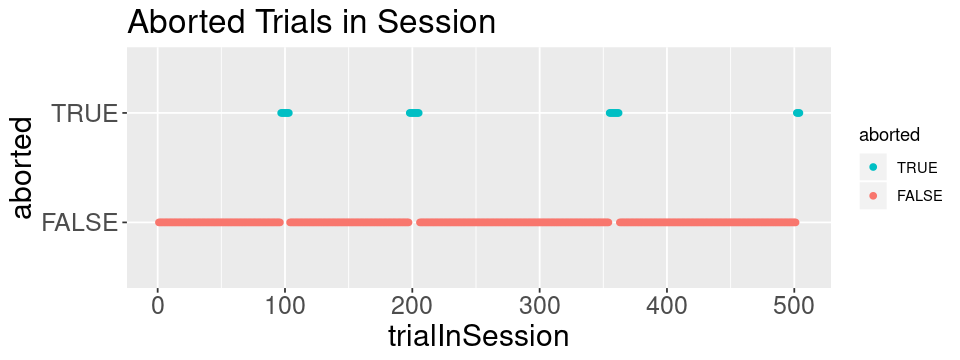

In [19]:
cat('there are',nrow(TRIALS[is.na(choice)]),'trials where choice = NA:')

# add two columns to TRIALS for convenience in following plot:
TRIALS[order(trialStart),trialInSession:=.I]
TRIALS[,aborted:=is.na(trialCount)]

# control output figure size
options(repr.plot.width=8, repr.plot.height=3)

ggplot(TRIALS, aes(x=trialInSession, y=aborted)) + 
    geom_point(aes(col=aborted)) +
    ggtitle("Aborted Trials in Session") +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
          plot.subtitle=element_text(size=15,family="American Typewriter"),  # subtitle
          plot.caption=element_text(size=15),  # caption
          axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
          axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
          axis.text.x=element_text(size=AXES_FONT),  # X axis text
          axis.text.y=element_text(size=AXES_FONT)) + # Y axis text
    guides(colour = guide_legend(reverse=T))

<!-- this is not so important anymore.
Were some trials presented again after failure? -->

In [ ]:
# print("below are the trial counts corresponding to trials that were presented a second time (lapse)")
# TRIALS[,.(trialIndex, trialCount)][duplicated(TRIALS[,.(trialIndex)])]

- How many trials were produced per combination of factors? **(TODO: any better way of displaying these results?)**

In [ ]:
indepVarNames <- c("initDirection","presenceCP","coherence","viewingDuration","probCP","timeCP")
combFactors <- getFreq(TRIALS, indepVarNames)
combFactors

- What were the marginal frequencies? **(TODO:improve visualization)**

In [ ]:
for (i in 1:length(indepVarNames)) {
  print(getFreq(TRIALS, indepVarNames[i]))
}

## Random indep vars.
We now plot the independent variables as a function of trial number in the task, to check randomization (at least eye-balling).

In [ ]:
p1 <- ggplot(TRIALS, aes(x=trialCount, y=dotsOff - dotsOn)) + geom_line()
p2 <- ggplot(TRIALS, aes(x=trialCount, y=coherence)) + geom_line()
p3 <- ggplot(TRIALS[trialCount < 50], aes(x=trialCount, y=initDirection)) + geom_line() + geom_point(aes(col=factor(presenceCP)))
p4 <- ggplot(TRIALS[trialCount < 50], aes(x=trialCount, y=endDirection)) + geom_line() + geom_point(aes(col=factor(presenceCP)))
p5 <- ggplot(TRIALS, aes(x=trialCount, y=presenceCP)) + geom_line()
grid.arrange(p1,p2,p3,p4,p5, nrow=5) 

## A deeper look at the timestamps fields

In [ ]:
wideTimestamps <- TRIALS[,.(trialStart=trialStart-trialStart,
                                  trialEnd=trialEnd-trialStart,
                                  dotsOn,
                                  dotsOff,
                                  tocDotsOn,
                                  tocDotsOff,
                                  nDotsOn=dotsOn - tocDotsOn,
                                  nDotsOff=dotsOff - tocDotsOn,
                                  nTocDotsOn=tocDotsOn - tocDotsOn,
                                  nTocDotsOff=tocDotsOff - tocDotsOn,
                                  targetOn,
                                  fixationOn,
                                  choiceTime,
                                  trialCount,
                                  presenceCP),by=trialIndex]

In [ ]:
# refTime <- wideTimestamps[,.(trialCount,
#     trialStart, trialEnd, dotsOn, dotsOff, targetOn, fixationOn, choiceTime), 
#                         by=trialIndex]
longTimestamps <- melt(wideTimestamps,
                       id.vars=c("trialCount"),
                       measure.vars=c("trialStart","fixationOn","targetOn","dotsOn","dotsOff",
                                      "choiceTime","trialEnd"),
                       value.name="timestamp", variable.name="Event")
# str(longTimestamps)

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=8)
# plot
ggplot(longTimestamps, aes(x=trialCount, y=timestamp)) + geom_point(aes(col=Event), size=2) +
   geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
    guides(colour = guide_legend(reverse=T)) +
    labs(title="Trial Timestamps",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="Aligned Time (sec)") + theme(plot.title=element_text(size=20,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15,
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

### Dots timing

We plot `(dotsOff - dotsOn) - viewingDuration`, across all trials, and overlay average durations of 1 and 2 frames (dashed lines).

In [ ]:
durTable <- TRIALS[,.(dotsDurationError = (dotsOff - dotsOn - viewingDuration) * 1000, 
                            presenceCP, 
                            viewingDuration), 
                        by=trialCount]

horizLines <- c(FRAME_DURATION*1000,FRAME_DURATION * 2000)

# call to ggplot()
g <- ggplot(durTable, aes(x=trialCount, y=dotsDurationError)) + 
#   geom_line(size=.2) +  
  geom_point(aes(shape=factor(presenceCP), col=factor(viewingDuration)),size=3) +
  geom_hline(yintercept = horizLines, linetype="dashed") +
  annotate("text", x=37, y=horizLines, vjust = 1.3, label = c("1 frame","2 frames"))
# Add Title and Labels
g + labs(title="Error in generated dots duration", 
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""), 
         y="duration error (msec)", 
         x="trial (in session order)",
         color="viewing dur.", shape="CP") + theme(plot.title=element_text(size=20, 
                                    family="American Typewriter",
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, 
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

Below I try to estimate the mean errors, clustered. 

In [ ]:
print("empty for now")
# intervals <- bin(durTable[,.(dotsDurationError)], nbins = 3, method = "cluster")
# names(intervals) <- "interval"

# # add the bins as a factor to the data.table
# durTable[, ("interval") := intervals]

# # compute mean durations
# unordered <- durTable[, .(num_trials=.N, meanDurationError = mean(dotsDurationError)), by = intervals]

# # display results, with num_frame column
# unordered[order(meanDurationError),.(num_trials, meanDurationError, num_frames = (meanDurationError * FRAME_RATE_ESTIMATE / 1000))]

### Tic/toc dots durations
Below I specifically compare the `dotsOn` and `dotsOff` values that I got from the task and from the `tic/toc` 
calls.

In [ ]:
longDotsOffTimestamps <- melt(wideTimestamps,
                       id.vars=c("trialIndex","presenceCP"),
                       measure.vars=c("nTocDotsOn","nDotsOn","nTocDotsOff","nDotsOff"),
                       value.name="timestamp", variable.name="Event")

# control output figure size
options(repr.plot.width=8, repr.plot.height=8)

# plot
ggplot(longDotsOffTimestamps, aes(x=trialIndex, y=timestamp)) + 
   geom_point(aes(col=Event, shape=factor(presenceCP)), size=2) +
#    geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
    guides(colour = guide_legend(reverse=T)) +
    labs(title="Trial Timestamps",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
        shape="Change Point") + theme(plot.title=element_text(size=20,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15,
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

# Checking that the three datasets are consistent

## Timing of trial vs. timing of frames

In [ ]:
# we work on a custom data.table containing the frames data and a few columns from the TRIALS table

# the syntax is that of a right join
frameTimes <- FRAMES[TRIALS[,.(trialStart, 
                                           dotsOn, 
                                           dotsOff, 
                                           trialIndex, trialCount)], on="trialIndex"]

# only consider frames with onsetTime in-between dotsOn and dotsOff
frameTimes <- frameTimes[onsetTime-trialStart>=dotsOn & onsetTime-trialStart <= dotsOff]

- does the "number of frames" match across the three files? **THERE IS A PB BELOW!**

In [ ]:
# we now create a custom data.table to hold the frame count from the three files.

# Full OUTER JOIN (see https://rstudio-pubs-static.s3.amazonaws.com/52230_5ae0d25125b544caab32f75f0360e775.html)
frameCount <- merge(
    TRIALS[,.(numInTRIALS=numFrames, trialCount),by=trialIndex],
    frameTimes[,.(numInFRAMES=.N),by=trialIndex],
    all=TRUE)

# str(frameCount)

In [ ]:
# and we add the frame count from the DOTS table
frameCount <- frameCount[DOTS[,.(numInDOTS=max(frameIdx)),by=trialCount],on="trialCount"]

print("trials on which frame counts between DOTS and FRAMES don't match")
frameCount[numInFRAMES != numInDOTS,.(trialIndex, trialCount, numInTRIALS,numInFRAMES,numInDOTS)]

From the columns above, we see that:
- the `numFrames` field from the `TRIALS` table is not useful
- I should match dots and frames using timestamps

### Frame timings
what time gaps do I observe between `dotsOn` and 1st frame `onsetTime`, and last frame `onsetTime` and `dotsOff`?

In [ ]:
# get times of first and last frame in each trial, align everything to dotsOn
extremeFrameTimes <- frameTimes[,.(firstFrame=min(onsetTime-trialStart)-dotsOn, 
                                   lastFrame=max(onsetTime-trialStart)-dotsOn,
                                   trialStart, 
                                   dotsOn=dotsOn-dotsOn, 
                                   dotsOff=dotsOff-dotsOn,
                                   trialCount),
                                  by=trialIndex]
# str(extremeFrameTimes)

In [ ]:
1.3# transform to long format for ggplot 
longTimeData <- melt(extremeFrameTimes, 
                    id.vars=c("trialIndex"),
                    measure.vars=c("dotsOn","firstFrame","lastFrame","dotsOff"),
                    variable.name="Event", value.name="timestamp")
#str(longTimeData)


frameDurations <- c(6*FRAME_DURATION, 140*FRAME_DURATION)

# control output figure size
options(repr.plot.width=8, repr.plot.height=8)

# plot
ggplot(longTimeData, aes(x=trialIndex, y=timestamp)) + geom_point(aes(col=Event), size=2) +
#    geom_line(aes(col=Event),size=.2) +
   geom_hline(yintercept = FRAME_DURATION, linetype="dashed") +
   annotate("text", x=16, y=FRAME_DURATION, vjust = -1, label = c("1 frame")) +
   guides(colour = guide_legend(reverse=T)) +
   labs(title="Stimulus Timestamps",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="Aligned Time (sec)") + theme(plot.title=element_text(size=20,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15,
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

### Tight/skipped frames
Exploration of `Tight` frames in each trial

In [ ]:
# plot
ggplot(frameTimes, aes(x=trialIndex, y=onsetTime-(dotsOn+trialStart))) + 
   geom_point(aes(col=factor(isTight)), size=2) +
#    geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
#    guides(colour = guide_legend(reverse=T)) +
   labs(title="Tight/Untight Frames",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="onsetTime aligned to dotsOn (sec)",
        color="Tight") + 
   theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

In [ ]:
cat('total of skipped frames = ',frameTimes[,sum(!isTight)])

In [ ]:
frameTimes[isTight == 0, .(trialIndex, trialCount)]

## Exploring match between `FRAMES` and `DOTS`

In [ ]:
# unique(DOTS[,frameIdx])
# DOTS[order(trialIndex),.(frameIdx), by=.(trialIndex, frameIdx)]

# Accuracy analysis
- Accuracy (% correct) on all trials with non-zero coherence

In [ ]:
accuracy <- sum(TRIALS[coherence > 0,correct])/numTrials
cat('accuracy on trials with non-zero coherence:', accuracy * 100,"%", sep = '')

## Psychophysical curves
Recall that rightward motion corresponds to direction 0 degrees and choice 1.
Below, we set the coherence to its negative counterpart every time 
the direction of motion at the end of the trial is leftward (180 degrees).

In [ ]:
# create a specific column signedCoherence
TRIALS[, signedCoherence := coherence]
TRIALS[endDirection==180, signedCoherence := -coherence]

z <- 1.96 # For 95% confidence intervals
# create new data.table with columns "propChooseRight" and "se" (for standard error)
ppTable1 <- TRIALS[, .(propChooseRight=sum(choice)/.N, n=.N), by=signedCoherence]
ppTable1[,se:=sqrt(propChooseRight*(1-propChooseRight)/n)]
ppTable1[,ci:=z*se]

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=5)
ggplot(ppTable1, aes(x=signedCoherence, y=propChooseRight)) +
    geom_errorbar(aes(ymin=propChooseRight-ci, ymax=propChooseRight+ci), width=ERROR_WIDTH) +
    geom_line() +
    geom_point() +
    ggtitle("Psychophysical curve\nwith 95% confidence intervals") +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

### Psychophysical curves grouped by change-point condition
Let's compute the same curve, separating CP and non-CP trials

In [ ]:
ppTableCP <- TRIALS[presenceCP==1, .(propChooseRightCP=sum(choice)/.N, nCP=.N), by=signedCoherence]
ppTableCP[,seCP:=sqrt(propChooseRightCP*(1-propChooseRightCP)/nCP)]
ppTableNonCP <- TRIALS[presenceCP==0, .(propChooseRightNonCP=sum(choice)/.N, nNonCP=.N), by=signedCoherence]
ppTableNonCP[,seNonCP:=sqrt(propChooseRightNonCP*(1-propChooseRightNonCP)/nNonCP)]

In [ ]:
# merge the two tables and put them in long format
setkey(ppTableCP, signedCoherence)
setkey(ppTableNonCP, signedCoherence)

# Full OUTER JOIN (see https://rstudio-pubs-static.s3.amazonaws.com/52230_5ae0d25125b544caab32f75f0360e775.html)
psychophys <- merge(ppTableCP,ppTableNonCP,all=TRUE)

# convert to long format
longPsychophys <- melt(psychophys, 
                    id.vars=c("signedCoherence","seCP","seNonCP"),
                    measure.vars=c("propChooseRightCP","propChooseRightNonCP"),
                    variable.name="CPcategory", value.name="propChooseRight")

# add se col
longPsychophys[,se:=seCP]
longPsychophys[CPcategory=='propChooseRightNonCP', se:=seNonCP]
longPsychophys[,ci:=z*se]

# head(psychophys)
# head(longPsychophys)

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=5)

# ref on error bars
# http://www.cookbook-r.com/Graphs/Plotting_means_and_error_bars_(ggplot2)/

pd <- position_dodge(1.5)
# ggplot(longPsychophys, aes(x=signedCoherence, y=propChooseRight)) +
#     geom_errorbar(aes(ymin=propChooseRight-ci, ymax=propChooseRight+ci, col=CPcategory), width=.1, position=pd) +
#     geom_line(aes(col=CPcategory),position=pd) +
#     geom_point(aes(col=CPcategory),position=pd)

ggplot(longPsychophys, aes(x=signedCoherence, y=propChooseRight, colour=CPcategory, group=CPcategory)) + 
    geom_errorbar(aes(ymin=propChooseRight-ci, ymax=propChooseRight+ci), colour="black", width=ERROR_WIDTH, position=pd) +
    geom_line(position=pd, size=LINE_WIDTH) +
    geom_point(position=pd, size=3, shape=21, fill="white") + # 21 is filled circle
    xlab("% coherence (+- for direction)") +
    ylab("Proportion Choose Right") +
    scale_colour_hue(name="Trial type",    # Legend label, use darker colors
                     breaks=c("propChooseRightCP", "propChooseRightNonCP"),
                     labels=c("CP", "No CP"),
                     l=40) +                    # Use darker colors, lightness=40
    ggtitle("Psychophysics curves grouped by CP presence\nwith 95% confidence intervals") +
    expand_limits(y=0) +                        # Expand y range
    scale_y_continuous(breaks=c(0,.25,0.5,0.75,1)) +         # Set tick every 4
    theme_bw() +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
          plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
          plot.caption=element_text(size=15),  # caption
          axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
          axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
          axis.text.x=element_text(size=AXES_FONT),  # X axis text
          axis.text.y=element_text(size=AXES_FONT),  # Y axis text
          legend.justification=c(1,0),
          legend.position=c(1,0))               # Position legend in bottom right

## Accuracy as a function of viewing duration

In [ ]:
# first get marginal frequencies
toDisplay <- TRIALS[coherence > 0,.(freq = .N, correct = sum(correct)), by=viewingDuration]

# then add the accuracy column
toDisplay[,accuracy := correct/freq]
toDisplay[,se := sqrt(accuracy * (1-accuracy)/ freq)]

# head(toDisplay)

pd <- position_dodge(0)
ggplot(toDisplay, aes(x=viewingDuration, y=accuracy)) +
    geom_errorbar(aes(ymin=accuracy-z*se, ymax=accuracy+z*se), width=0.03, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd) +
    ggtitle("Percent correct on non-zero coherence trials\n 95% confidence intervals") +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

### Grouped by change-point condition
And now separating according to change point trials:

In [ ]:
# first get marginal frequencies
accDuration <- TRIALS[coherence > 0,.(freq = .N, correct = sum(correct)), by=.(viewingDuration,presenceCP)]


# then add the accuracy column
accDuration[,accuracy := correct/freq]

# head(accDuration)

# # conver to long format
# longAccDuration <- melt(accDuration, 
#                     id.vars=c("viewingDuration"),
#                     measure.vars=c("accuracy"),
#                     variable.name="CPcategory", value.name="accuracy")

# head(longAccDuration)

# add standard error column
accDuration[,se := sqrt(accuracy * (1-accuracy)/ freq)]

# set presenceCP to factor variable
accDuration[,presenceCP := as.factor(presenceCP)]

# head(toDisplay)

# control output figure size
options(repr.plot.width=8, repr.plot.height=7)

pd <- position_dodge(.01)

ggplot(accDuration, aes(x=viewingDuration, y=accuracy, colour=presenceCP, group=presenceCP)) + 
    geom_errorbar(aes(ymin=accuracy-z*se, ymax=accuracy+z*se), width=SMALL_ERROR_WIDTH, colour="black", position=pd) +
    geom_line(position=pd, size=LINE_WIDTH) +
    geom_point(position=pd, size=3, shape=21, fill="white") + # 21 is filled circle
    xlab("viewing duration (sec)") +
    ylab("Percent Correct") +
    scale_colour_hue(name="CP presence",    # Legend label, use darker colors
#                      breaks=c("propChooseRightCP", "propChooseRightNonCP"),
#                      labels=c("CP", "No CP"),
                     l=40) +                    # Use darker colors, lightness=40
    ggtitle("Accuracy as function of viewing duration\nwith 95% confidence intervals (and 0%-coh excluded)") +
    expand_limits(y=c(0.5,1)) +                        # Expand y range
    scale_y_continuous(breaks=c(0.5,0.75,1)) +         # Set tick every 4
    theme_bw() +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
          plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
          plot.caption=element_text(size=15),  # caption
          axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
          axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
          axis.text.x=element_text(size=AXES_FONT),  # X axis text
          axis.text.y=element_text(size=AXES_FONT),  # Y axis text
          legend.justification=c(1,0),
          legend.position=c(1,0))               # Position legend in bottom right
  

## Accuracy as a function of coherence level

In [ ]:
# first get marginal frequencies
accCoh <- TRIALS[,.(freq = .N, correct = sum(correct)), by=coherence]

# then add the accuracy column
accCoh[,accuracy := correct/freq]
accCoh[,se := sqrt(accuracy * (1-accuracy)/ freq)]
# deal with coh=0 artificially
accCoh[coherence==0, accuracy:=0.5]
accCoh[coherence==0, se:=0]

# control output figure size
options(repr.plot.width=8, repr.plot.height=5)

# pd <- position_dodge(0)
ggplot(accCoh, aes(x=coherence, y=accuracy)) +
    geom_errorbar(aes(ymin=accuracy-z*se, ymax=accuracy+z*se), width=ERROR_WIDTH) +
    geom_line(size=.8*LINE_WIDTH) +
    geom_point(size=1.6*POINT_SIZE, fill="white", shape=21) +
    ggtitle("Percent correct as a 11:00amfunction of coherence\n 95% confidence intervals") +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

# Reverse Kernel Analysis

In [ ]:
head(DOTS)

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=4)
ggplot(DOTS[,.(numFrames=max(frameIdx)),by=trialCount],
      aes(x=trialCount,y=numFrames)) + geom_line() + geom_point()

Let's display the number of coherent dots on each frames, grouping by subject's choice.

In [ ]:
# count coherent dots on each frame
cohDots <- DOTS[,
                      .(numCohDots=sum(isCoherent), 
                        initDirection, 
                        endDirection, 
                        presenceCP),
                      by=.(frameIdx, trialCount)]

# see if some frames have 0 coherent dots
unique(cohDots[numCohDots == 0,.(trialCount,frameIdx)])

In [ ]:
# let's try to sign numCohDots according to the direction of motion (+ for R and - for L)
## add a copy of numCohDots column named signedNumCohDots, and an ID col that just indexes the rows
cohDots[,"signedNumCohDots" := .(numCohDots)]

In [ ]:
## on non-cp trials, adjust sign according to initDirection
cohDots[initDirection == 180 & presenceCP == 0, signedNumCohDots := -numCohDots] 

In [ ]:
## on cp-trials,
    # rough estimate of number of frames that are before the CP (for now)
if (length(unique(TRIALS$timeCP)) == 1) {
    foreFrameCount <- TRIALS[,timeCP][1] * FRAME_RATE_ESTIMATE
} 

In [ ]:
foreFrameCount

In [ ]:
rows <- cohDots[, .(rowNumber=.I[initDirection==180 & presenceCP == 1]), by=.(trialCount,frameIdx)]
cohDots[["signedNumCohDots"]][
    rows[frameIdx <= foreFrameCount,rowNumber]] <- -cohDots[["numCohDots"]][
        rows[frameIdx <= foreFrameCount,rowNumber]]

In [ ]:
rows <- cohDots[, .(rowNumber=.I[initDirection==0 & presenceCP == 1]), by=.(trialCount,frameIdx)]
cohDots[["signedNumCohDots"]][
    rows[frameIdx > foreFrameCount,rowNumber]] <- -cohDots[["numCohDots"]][
        rows[frameIdx > foreFrameCount,rowNumber]]

In [ ]:
# diagnostic
unique(cohDots[presenceCP == 1,
               .(initDirection,endDirection,presenceCP,numCohDots,signedNumCohDots) ,
               by=.(frameIdx,trialCount)])

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=60)

# add ID col to DOTS and cohDots to perform a join
DOTS[,ID:=.I]
cohDots[,rowNumber := NULL]
cohDots[,ID:=.I]

# plot
ggplot(DOTS[cohDots, on=c("ID","frameIdx","trialCount")], aes(x=frameIdx, y=signedNumCohDots)) + 
    geom_point(aes(col=factor(correct), shape=factor(presenceCP)), size=2) +
    facet_grid(trialIndex~coherence) +
#    geom_line(aes(col=Event),size=.2) +
    geom_hline(yintercept = 0) +
    guides(colour = guide_legend(reverse=T), shape = guide_legend(reverse=T)) +
    labs(title="Signed # of Coherent Dots per Frames per Trials",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="# Coherent Dots",
         x="Frame #",
         color="Correct", shape="Change Point") + 
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),                                 # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

# Miscellaneous
##  Explore random seed

In [ ]:
seedTable <- TRIALS[,.(randSeedBase,trialIndex),by=trialCount]

# control output figure size
options(repr.plot.width=7, repr.plot.height=6)

g <- ggplot(seedTable, aes(x=trialCount, y=randSeedBase)) + 
  geom_line(size=.2) #+  geom_point(aes(shape=factor(presenceCP), col=factor(viewingDuration)),size=3) 

# Add Title and Labels
g + labs(title="Random seed base", 
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""), 
         y="randSeedBase", 
         x="trial (in session order)") + theme(plot.title=element_text(size=20, 
                                    family="American Typewriter",
                                    color="tomato",
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, 
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text